# Sample Mass-Difference Networks in Metabolomics Data Analysis

Notebook to support the study on the application of **Sample M**ass-**Di**fference **N**etworks as a highly specific competing form of pre-processing procedure for high-resolution metabolomics data.

Mass-Difference Networks are focused into making networks from a list of masses. Each _m/z_ will represent a node. Nodes will be connected if the difference in their masses can be associated to a simple chemical reaction (enzymatic or non-enzymatic) that led to a change in the elemental composition of its metabolite.

The set of mass differences used to build said networks are called a set of MDBs - Mass-Difference-based Building block.

This is notebook `paper_sMDiNs_permuts.ipynb`


## Organization of the Notebook

- Loading up pre-processed and pre-treated datasets databases with intensity-based pre-treated data and data from sMDiNs analyses.
- **Permutation tests generation and figure representation**

Permutation tests are slow to generate.

#### Needed Imports

In [1]:
import itertools
from pathlib import Path

import numpy as np
import pandas as pd
from pandas.testing import assert_frame_equal
from numpy.random import default_rng

import scipy.spatial.distance as dist
import scipy.cluster.hierarchy as hier
import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from matplotlib import ticker

import sklearn.ensemble as skensemble
from sklearn.cross_decomposition import PLSRegression

import seaborn as sns
import networkx as nx

# Metabolinks package
import metabolinks as mtl
import metabolinks.transformations as transf

# Python files in the repository
import multianalysis as ma

# json for persistence

import json
from time import perf_counter

In [2]:
%matplotlib inline

## Description of dataset records

`datasets` is the global dict that holds all data sets. It is a **dict of dict's**.

Each data set is **represented as a dict**.

Each record has the following fields (keys):

- `name`: the table/figure name of the data set
- `source`: the biological source for each dataset
- `mode`: the aquisition mode
- `alignment`: the alignment used to generate the data matrix
- `data`: the data matrix
- `target`: the sample labels, possibly already integer encoded
- `MDiN`: Mass-Difference Network - Not present here, only on sMDiNsAnalysis notebook
- `<treatment name>`: transformed data matrix / network. These treatment names can be
    - `Ionly`: missing value imputed data by 1/5 of the minimum value in each sample in the dataset, only
    - `NGP`: normalized, glog transformed and Pareto scaled
    - `Ionly_RF`: missing value imputed data by random forests, only
    - `NGP_RF`: normalized, glog transformed and Pareto scaled
    - `IDT`: `NGP_RF` or `NGP` - Intensity-based Data pre-Treatment chosen as comparison based on which of the two performed better for each dataset and each statistical method
    - `sMDiN`: Sample Mass-Difference Networks - Not present here, only on sMDiNsAnalysis notebook
       
- `<sMDiN analysis name>`: data matrix from nework analysis of MDiNs - Not in this notebook
    - `Degree`: degree analysis of each sMDiN
    - `Betweenness`: betweenness centrality analysis of each sMDiN
    - `Closeness`: closeness centrality of analysis of each sMDiN
    - `MDBI`: analysis on the impact of each MDB (Mass-Difference based building-block) on building each sMDiN
    - `GCD11`: Graphlet Correlation Distance of 11 different orbits (maximum of 4-node graphlets) between each sMDiN.
    - `WMDBI`: an alternative calculation of MDBI using the results from the degree analysis.

- `iter_fold_splits`: contains nested dicts that identify and contain each transformed training and testing groups data matrices with their respective iteration, training/test, fold number and one of the previously mentioned data pre-treatments
- `train`: specific to the HD dataset; contains a set of the different pre-treatments and sMDin analysis mentioned and a target based on the training set defined for HD
- `test`: specific to the HD dataset; contains a set of the different pre-treatments and sMDin analysis mentioned and a target based on the external test set defined for HD


The keys of `datasets` may be shared with dicts holding records resulting from comparison analysis.

Here are the keys (and respective names) of datasets used in this study:

- GD_neg_global2 (GDg2-)
- GD_neg_class2 (GDc2-)
- YD (YD)
- vitis_types (GD types)
- HD (HD)

#### Data Pre-Treatment

For information on the **commonly used intensity based data pre-treatments** and about the **benchmark datasets**, see notebook `paper_sMDiNs_database_prep.ipynb`.

For information on the **building** and the different **network analysis methods** used for the **Sample MDiNs** and information about the Mass-Difference-based Building blocks (**MDBs**), see notebook `paper_sMDiNs_sMDiNsAnalysis.ipynb`.

### Reading datasets database

In [3]:
# Where the datasets are
path = Path.cwd() / "store_files" / 'processed_data.json'
storepath = Path.cwd() / "store_files" / 'processed_data.h5'
with pd.HDFStore(storepath) as store:
    
    # Read into a dictionary not DataFrame data
    with open(path, encoding='utf8') as read_file:
        datasets = json.load(read_file)
    
    # Add DataFrame data to dict
    for dskey, dataset in datasets.items():
        dataset['iter_fold_splits'] = {}
        if dskey == 'HD':
            dataset['train'] = {}
            dataset['test'] = {}
        for key in dataset:
            # Created right before
            if 'iter_fold_splits' == key:
                continue
            value = dataset[key]
            if isinstance(value, str) and value.startswith("INSTORE"):
                storekey = value.split("_", 1)[1]
                #print(storekey)
                # Load the data from 'iter_fold_splits' carefully restoring the nested dictionaries
                if len(storekey.split("AA_")) > 1: # This separation was made to identify the 'iter_fold_splits' data
                    dictkeys = (storekey.split("AA_")[1]).split('_',3)
                    # Create nested dicts
                    if int(dictkeys[0]) not in dataset['iter_fold_splits'].keys():
                        dataset['iter_fold_splits'][int(dictkeys[0])] = {}
                    if dictkeys[1] not in dataset['iter_fold_splits'][int(dictkeys[0])].keys():
                        dataset['iter_fold_splits'][int(dictkeys[0])][dictkeys[1]] = {}
                    if int(dictkeys[2]) not in dataset['iter_fold_splits'][int(dictkeys[0])][dictkeys[1]].keys():
                        dataset['iter_fold_splits'][int(dictkeys[0])][dictkeys[1]][int(dictkeys[2])] = {}
                    dataset['iter_fold_splits'][int(dictkeys[0])][dictkeys[1]][int(dictkeys[2])][dictkeys[3]] = store[storekey]
                
                # Load the data from 'train' and 'test' from HD dataset keys carefully restoring the nested dictionaries
                elif len(storekey.split("TTS_")) > 1:
                    dictkeys = ((storekey.split("TTS_")[0]).split('_')[-1], storekey.split("TTS_")[1])#.split('_',2)
                    dataset[dictkeys[0]][dictkeys[1]] = store[storekey]
                # Normal DataFrames
                else:
                    dataset[key] = store[storekey]

            # convert colors to tuples, since they are read as lists from json file
            elif key == 'label_colors':
                dataset[key] = {lbl: tuple(c) for lbl, c in value.items()}
            elif key == 'sample_colors':
                dataset[key] = [tuple(c) for c in value]
            elif key.endswith('target') and key.startswith(dskey):
                if len(key.split("AA_")) > 1: 
                    dictkeys = ((key.split("_", 1)[1]).split("AA_")[1]).split('_',3)
                    dataset['iter_fold_splits'][int(dictkeys[0])][dictkeys[1]][int(dictkeys[2])][dictkeys[3]] = value
                else:
                    dictkeys = ((key.split("TTS_")[0]).split('_')[-1], key.split("TTS_")[1])#.split('_',2)
                    dataset[dictkeys[0]][dictkeys[1]] = value

# Remove extra keys
for name, ds in datasets.items():
    keys_to_remove = [keys for keys in ds.keys() if keys.startswith(name)]
    for key in keys_to_remove:
        ds.pop(key)
#datasets

In [4]:
# Selecting a placeholder for the Intensity-based Data pre-Treatment (IDT)
# Chosen for each dataset and each method based on which between NGP and NGP_RF generated the best results
for name, ds in datasets.items():
    ds['IDT'] = ds['NGP_RF']  

Extra Possibly Useful Data

In [5]:
# Chemical Formula transformations (MDBs chosen)
MDB = ['H2','CH2','CO2','O','CHOH','NCH','O(N-H-)','S','CONH','PO3H','NH3(O-)','SO3','CO', 'C2H2O', 'H2O']
MDB_YD = ['H2','CH2','CO2','O','CHOH','NCH','O(N-H-)','S','CONH','PO3H','NH3(O-)','SO3','CO', 'C2H2O', 'H2O', 
          'C2H2O2', 'C3H4O2']

### Colors for plots to ensure consistency

#### 11 variety grapevine data sets

In [6]:
# customize label colors for 11 grapevine varieties

colours = sns.color_palette('Blues', 3)
colours.extend(sns.color_palette('Greens', 3))
#colours = sns.cubehelix_palette(n_colors=6, start=2, rot=0, dark=0.2, light=.9, reverse=True)
colours.extend(sns.color_palette('flare', 5))

ordered_vitis_labels = ('CAN','RIP','ROT','RU','LAB','SYL','REG','CS','PN','RL','TRI')

vitis_label_colors = {lbl: c for lbl, c in zip(ordered_vitis_labels, colours)}

tab20bcols = sns.color_palette('tab20b', 20)
tab20ccols = sns.color_palette('tab20c', 20)
tab20cols = sns.color_palette('tab20', 20)
tab10cols = sns.color_palette('tab10', 10)
dark2cols = sns.color_palette('Dark2', 8)

vitis_label_colors['RU'] = tab20bcols[8]
vitis_label_colors['CAN'] = tab20ccols[5]
vitis_label_colors['REG'] = tab10cols[3]

for name in datasets:
    if name.startswith('GD'):
        datasets[name]['label_colors'] = vitis_label_colors
        datasets[name]['sample_colors'] = [vitis_label_colors[lbl] for lbl in datasets[name]['target']]

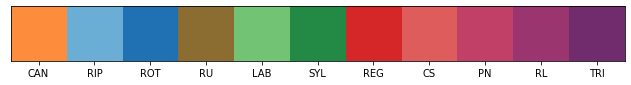

In [7]:
sns.palplot(vitis_label_colors.values())
new_ticks = plt.xticks(range(len(ordered_vitis_labels)), ordered_vitis_labels)

#### 5 yeast strains

In [8]:
# customize label colors for 5 yeast strains

colours = sns.color_palette('Set1', 5)
yeast_classes = datasets['YD']['classes']
yeast_label_colors = {lbl: c for lbl, c in zip(yeast_classes, colours)}
datasets['YD']['label_colors'] = yeast_label_colors
datasets['YD']['sample_colors'] = [yeast_label_colors[lbl] for lbl in datasets['YD']['target']]

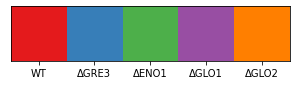

In [9]:
sns.palplot(yeast_label_colors.values())
new_ticks = plt.xticks(range(len(yeast_classes)), yeast_classes)

#### 2 classes of Vitis types (wild and _vinifera_)

In [10]:
# customize label colors for 2 types of Vitis varieties

colours = [vitis_label_colors['SYL'], vitis_label_colors['TRI']]
vitis_type_classes = datasets['vitis_types']['classes']
vitis_types_label_colors = {lbl: c for lbl, c in zip(vitis_type_classes, colours)}
datasets['vitis_types']['label_colors'] = vitis_types_label_colors
datasets['vitis_types']['sample_colors'] = [vitis_types_label_colors[lbl] for lbl in datasets['vitis_types']['target']]

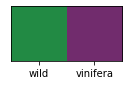

In [11]:
sns.palplot(datasets['vitis_types']['label_colors'].values())
new_ticks = plt.xticks(range(len(datasets['vitis_types']['classes'])), datasets['vitis_types']['classes'])

#### 2 HD classes

In [12]:
# customize label colors for 2 HD classes

colours = sns.color_palette('Set1', 2)
hd_label_colors = {lbl: c for lbl, c in zip(datasets['HD']['classes'], colours)}
datasets['HD']['label_colors'] = hd_label_colors
datasets['HD']['sample_colors'] = [hd_label_colors[lbl] for lbl in datasets['HD']['target']]

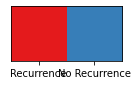

In [13]:
sns.palplot(hd_label_colors.values())
new_ticks = plt.xticks(range(len(datasets['HD']['classes'])), datasets['HD']['classes'])

Samples and respective target labels of each dataset

In [14]:
def styled_sample_labels(sample_names, sample_labels, label_colors):

    meta_table = pd.DataFrame({'label': sample_labels,
                               'sample': sample_names}).set_index('sample').T

    def apply_label_color(val):
        red, green, blue = label_colors[val]
        red, green, blue = int(red*255), int(green*255), int(blue*255)   
        hexcode = '#%02x%02x%02x' % (red, green, blue)
        css = f'background-color: {hexcode}'
        return css
    
    return meta_table.style.applymap(apply_label_color)

In [15]:
parsed = mtl.parse_data(datasets['GD_neg_class2']['data'], labels_loc='label')
y = datasets['GD_neg_class2']['target']
label_colors = datasets['GD_neg_class2']['label_colors']
s = styled_sample_labels(parsed.sample_names, y, label_colors)
s

sample,14,15,16,29,30,31,8,9,10,23,24,25,38,39,40,17,18,19,26,27,28,20,21,22,35,36,37,11,12,13,32,33,34
label,CAN,CAN,CAN,CS,CS,CS,LAB,LAB,LAB,PN,PN,PN,REG,REG,REG,RIP,RIP,RIP,RL,RL,RL,ROT,ROT,ROT,RU,RU,RU,SYL,SYL,SYL,TRI,TRI,TRI


In [16]:
parsed = mtl.parse_data(datasets['YD']['data'])
y = datasets['YD']['target']
label_colors = datasets['YD']['label_colors']
s = styled_sample_labels(parsed.sample_names, y, label_colors)
s

sample,BY0_1,BY0_2,BY0_3,GRE3_1,GRE3_2,GRE3_3,ENO1_1,ENO1_2,ENO1_3,dGLO1_1,dGLO1_2,dGLO1_3,GLO2_1,GLO2_2,GLO2_3
label,WT,WT,WT,ΔGRE3,ΔGRE3,ΔGRE3,ΔENO1,ΔENO1,ΔENO1,ΔGLO1,ΔGLO1,ΔGLO1,ΔGLO2,ΔGLO2,ΔGLO2


In [17]:
parsed = mtl.parse_data(datasets['vitis_types']['data'], labels_loc='label')
y = datasets['vitis_types']['target']
label_colors = datasets['vitis_types']['label_colors']
s = styled_sample_labels(parsed.sample_names, y, label_colors)
s

sample,14,15,16,29,30,31,8,9,10,23,24,25,38,39,40,17,18,19,26,27,28,20,21,22,35,36,37,11,12,13,32,33,34
label,wild,wild,wild,vinifera,vinifera,vinifera,wild,wild,wild,vinifera,vinifera,vinifera,vinifera,vinifera,vinifera,wild,wild,wild,vinifera,vinifera,vinifera,wild,wild,wild,wild,wild,wild,wild,wild,wild,vinifera,vinifera,vinifera


In [18]:
parsed = mtl.parse_data(datasets['HD']['data'])
y = datasets['HD']['target']
label_colors = datasets['HD']['label_colors']
s = styled_sample_labels(parsed.sample_names, y, label_colors)
s

sample,S10_1,S10_2,S10_3,S15_1,S15_2,S15_3,S25_1,S25_2,S25_3,S34_1,S34_2,S34_3,S35_1,S35_2,S35_3,S37_1,S37_2,S37_3,S39_1,S39_2,S39_3,S45_1,S45_2,S45_3,S48_1,S48_2,S48_3,S49_1,S49_2,S49_3,S50_1,S50_2,S50_3,S51_1,S51_2,S51_3,S52_1,S52_2,S52_3,S53_1,S53_2,S53_3,S54_1,S54_2,S54_3,S57_1,S57_2,S57_3,S58_1,S58_2,S58_3,S59_1,S59_2,S59_3,S60_1,S60_2,S60_3,S61_1,S61_2,S61_3,S62_1,S62_2,S62_3,S63_1,S63_2,S63_3,S64_1,S64_2,S64_3,S65_1,S65_2,S65_3,S68_1,S68_2,S68_3,S69A_1,S69A_2,S69A_3,S69B_1,S69B_2,S69B_3,S71_1,S71_2,S71_3,S73_1,S73_2,S73_3,S74_1,S74_2,S74_3,S75_1,S75_2,S75_3,S76_1,S76_2,S76_3,S78_1,S78_2,S78_3,S79_1,S79_2,S79_3,S80_1,S80_2,S80_3,S81_1,S81_2,S81_3,S82_1,S82_2,S82_3,S83_1,S83_2,S83_3,S1_1,S1_2,S1_3,S2_1,S2_2,S2_3,S3_1,S3_2,S3_3,S4_1,S4_2,S4_3,S5_1,S5_2,S5_3,S6_1,S6_2,S6_3,S8_1,S8_2,S8_3,S9_1,S9_2,S9_3,S11_1,S11_2,S11_3,S12_1,S12_2,S12_3,S13A_1,S13A_2,S13A_3,S13B_1,S13B_2,S13B_3,S14_1,S14_2,S14_3,S16_1,S16_2,S16_3,S17_1,S17_2,S17_3,S18_1,S18_2,S18_3,S19_1,S19_2,S19_3,S20A_1,S20A_2,S20A_3,S20B_1,S20B_2,S20B_3,S21_1,S21_2,S21_3,S22_1,S22_2,S22_3,S23_1,S23_2,S23_3,S24_1,S24_2,S24_3,S26_1,S26_2,S26_3,S27_1,S27_2,S27_3,S28_1,S28_2,S28_3,S29_1,S29_2,S29_3,S30_1,S30_2,S30_3,S31_1,S31_2,S31_3,S32_1,S32_2,S32_3,S33_1,S33_2,S33_3,S36_1,S36_2,S36_3,S38_1,S38_2,S38_3,S41_1,S41_2,S41_3,S42_1,S42_2,S42_3,S43_1,S43_2,S43_3,S44_1,S44_2,S44_3,S46_1,S46_2,S46_3,S47_1,S47_2,S47_3,S66A_1,S66A_2,S66A_3,S66B_1,S66B_2,S66B_3,S67_1,S67_2,S67_3,S70_1,S70_2,S70_3,S72_1,S72_2,S72_3,S77_1,S77_2,S77_3
label,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recu

#### Colors for the pre-treatments / sMDiN analysis metrics for the plots

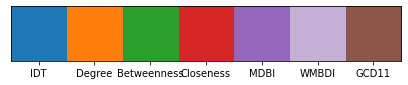

In [19]:
# customize colors for the intensity-based pre-treatment and analysis metrics of sample MDiNs
treatments = ('IDT', 'Degree', 'Betweenness', 'Closeness', 'MDBI', 'WMBDI', 'GCD11')

treat_colors = tab10cols[:4]
treat_colors.extend(tab20cols[8:10])
treat_colors.append(tab10cols[5])
treatment_colors = {lbl: c for lbl, c in zip(treatments, treat_colors)}

sns.palplot(treatment_colors.values())
new_ticks = plt.xticks(range(len(treatment_colors)), treatment_colors)

## Supervised Statistical Analysis - Permutation Tests

The Supervised Statistical Analysis methods used will be Random Forest and PLS-DA.

The performance of the classifiers will be evaluated by their predictive **accuracy** (which will always be estimated by internal stratified 3-fold cross-validation or 5-fold cross-validation in `vitis_types` and in `HD`).

Each method will be applied to the differently-treated datasets for each of the benchmark datasets.

In [20]:
# Creating the dictionaries in iter_fold_splits for the 5 sMDiN analysis (not created before, since there was no
# danger of data leakage, each network analysis is independent from network to network)
for name, ds in datasets.items():
    
    ds_iter = ds['iter_fold_splits']

    for itr in range(len(ds_iter.keys())):
        for fold in ds_iter[itr+1]['train'].keys():
            for treat in ('Degree', 'Betweenness', 'Closeness', 'MDBI', 'GCD11'):

                ds_iter[itr+1]['train'][fold][treat] = ds[treat].loc[ds_iter[itr+1]['train'][fold]['data'].index]
                ds_iter[itr+1]['test'][fold][treat] = ds[treat].loc[ds_iter[itr+1]['test'][fold]['data'].index]

## Permutation Tests (Very Slow)

Permutation tests is based on shuffling the labels of the different samples, shuflling the groups where they belong with the intent to see if the classifier tested, whether it is Random Forest or PLS-DA found a significant class structure in the data - assess the significance of the predictive accuracy results. 

For that a random k-fold cross-validation is performed on the original dataset (to serve as a comparation point) and on X permutations of datasets with labels randomly shuffled around. The models are evaluated by their predictive accuracies. 

The empirical p-value is given by (the number of times the permutation accuracy was bigger than the random k-fold cross-validation made with the original dataset + 1) / (number of permutations + 1) (source: Ojala and Garriga, 2010).

Ojala M, Garriga GC. Permutation Tests for Studying Classifier Performance. In: 2009 Ninth IEEE International Conference on Data Mining. ; 2009:908-913. doi:10.1109/ICDM.2009.108

Histograms with the prediction accuracy of the different permutations were plotted and compared to the accuracy got with the original dataset.

### Permutation Tests - Random Forests

Use of `permutation_RF` function from multianalysis.py. See details about the application of this function in the multianalysis.py file.

Use `GENERATE = True` to perform permutation tests and persist results in json

In [21]:
GENERATE = True #False

In [24]:
def permutation_RF(dataset, iter_num=100, n_trees=200, seed=None):
    """Performs permutation test n times of a dataset for Random Forest classifiers giving its predictive accuracy (estimated by
    stratified k-fold cross-validation) for the original and all permutations made and respective p-value.

       dataset: dictionary, dataset storage.
       iter_num: int (default - 100); number of permutations made.
       n_trees: int (default - 200); number of trees in each Random Forest.

       Returns: (scalar, list of scalars, scalar);
        estimated predictive accuracy of the non-permuted Random Forest model,
        estimated predictive accuracy of all permuted Random Forest models,
        p-value ((number of permutations with accuracy > original accuracy) + 1)/(number of permutations + 1).
    """
    
    # get a bit generator
    rng = default_rng(seed)
    
    # Iteration 1 of the the k-fold splits is used, ensuring the same split in the data is used for all permutations
    ds_iter = dataset['iter_fold_splits']
    
    # Setting up variables for result storing
    Perm = []
    
    # Dictionary of targets to shuffle and dataframe of the data to put columns in NewC shuffled order
    new_target = {}
    for fold in ds_iter[1]['train'].keys():
        new_target[fold] = ds_iter[1]['test'][fold]['target'].copy()
    label_dict = dict(zip(dataset['data'].index, dataset['target']))

    for _ in range(iter_num + 1):
        # Number of different permutations + original dataset where Random Forest cross-validation will be made
        # Set up targets for this iteration
        # 1st iteration (Non-permuted model), targets stay the same because new_target dict hasn't been shuffled yet
        for tg in new_target:
            for label in range(len(new_target[tg])):
                label_dict[ds_iter[1]['test'][tg]['data'].index[label]] = new_target[tg][label]
        
        perm = []
        
        # Repeat for each of the k groups the random forest model fit and classification
        for fold in ds_iter[1]['train'].keys():
            
            # Setup the permutated train target for fitting the random forest
            train_target = [label_dict[sample] for sample in ds_iter[1]['train'][fold]['data'].index]
            
            # Random Forest setup and fit
            rf = skensemble.RandomForestClassifier(n_estimators=n_trees)
            rf.fit(ds_iter[1]['train'][fold][treatment], train_target)
            
            # Compute performance
            perm.append(rf.score(ds_iter[1]['test'][fold][treatment], new_target[fold])) # Prediction Accuracy

        # Shuffle target labels for each stratified k-fold - 1 permutation of the columns (leads to permutation of labels)
        for tg in new_target:
            rng.shuffle(new_target[tg])

        # Appending K-fold cross-validation predictive accuracy
        Perm.append(np.mean(perm))

    # Taking out K-fold cross-validation accuracy for the non-shuffled (labels) dataset and p-value calculation
    CV = Perm[0] # Non-permuted dataset results - Perm [0]
    pvalue = (sum(Perm[1:] >= Perm[0]) + 1) / (iter_num + 1)

    return CV, Perm[1:], pvalue

In [ ]:
np.random.seed(16)
if GENERATE:
    iter_num=500 # number of permutations

    permuts_RF = []

    to_permute = [name for name in datasets]# if 'global2' in name]
    for name in to_permute:
        for treatment in ('IDT', 'Degree', 'Betweenness', 'Closeness', 'MDBI', 'WMDBI', 'GCD11'):
            dataset = datasets[name]
            # Choice based on prior results on which treatment tends to be better for the dataset/classifier combination
            # Based on the supervised analysis notebook
            if treatment == 'IDT':
                #if name == 'vitis_types':
                #    treatment = 'NGP_RF'
                #else:
                treatment = 'NGP'

            print(f'{iter_num} permutations (Random Forest) for {name} with treatment {treatment}', end=' ...')

            start = perf_counter()
            permutations = permutation_RF(dataset, iter_num=iter_num, n_trees=100, seed=16)
            
            if treatment in ('NGP', 'NGP_RF'):
                res = {'dataset': name, 'treatment': 'IDT',
                       'non_permuted_CV': permutations[0],
                       'permutations': permutations[1],
                       'p-value': permutations[2]}   
            else:
                res = {'dataset': name, 'treatment': treatment,
                       'non_permuted_CV': permutations[0],
                       'permutations': permutations[1],
                       'p-value': permutations[2]}       
            permuts_RF.append(res)
            end = perf_counter()
            pvalue = permutations[2]
            print(f'Done! took {(end - start):.3f} s, p-value = {pvalue}')
    
    # Store in json file
    fname = 'store_files/permuts_rf.json'
    with open(fname, "w", encoding='utf8') as write_file:
        json.dump(permuts_RF, write_file)

500 permutations (Random Forest) for GD_neg_global2 with treatment NGP ...Done! took 269.459 s, p-value = 0.001996007984031936
500 permutations (Random Forest) for GD_neg_global2 with treatment Degree ...Done! took 201.778 s, p-value = 0.001996007984031936
500 permutations (Random Forest) for GD_neg_global2 with treatment Betweenness ...Done! took 198.609 s, p-value = 0.001996007984031936
500 permutations (Random Forest) for GD_neg_global2 with treatment Closeness ...Done! took 196.440 s, p-value = 0.001996007984031936
500 permutations (Random Forest) for GD_neg_global2 with treatment MDBI ...Done! took 181.888 s, p-value = 0.001996007984031936
500 permutations (Random Forest) for GD_neg_global2 with treatment WMDBI ...Done! took 181.848 s, p-value = 0.001996007984031936
500 permutations (Random Forest) for GD_neg_global2 with treatment GCD11 ...Done! took 180.932 s, p-value = 0.001996007984031936
500 permutations (Random Forest) for GD_neg_class2 with treatment NGP ...Done! took 256.3

In [29]:
# Store in json file
fname = 'store_files/permuts_rf.json'
with open(fname, "w", encoding='utf8') as write_file:
    json.dump(permuts_RF, write_file)

### Permutation Tests - PLS-DA

Use of `permutation_PLSDA` function from multianalysis.py. See details about the application of this function in the multianalysis.py file.

In [22]:
def permutation_PLSDA(dataset, n_comp=10, iter_num=100, encode2as1vector=True, seed=None):
    """Performs permutation test n times of a dataset for PLS-DA classifiers giving its predictive accuracy (estimated by
    stratified k-fold cross-validation) for the original and all permutations made and respective p-value.

       dataset: dictionary, dataset storage.
       n_comp: integer; number of components to use in PLS-DA.
       iter_num: int (default - 100); number of permutations made (times labels are shuffled).

       Returns: (scalar, list of scalars, scalar);
        estimated predictive accuracy of the non-permuted PLS-DA model,
        estimated predictive accuracy of all permuted PLS-DA models,
        p-value ((number of permutations with accuracy > original accuracy) + 1)/(number of permutations + 1).
    """
    
    # get a bit generator
    rng = default_rng(seed)
    
    # Iteration 1 of the the k-fold splits is used, ensuring the same split in the data is used for all permutations
    ds_iter = dataset['iter_fold_splits']
    
    # list to store results
    Accuracy = []

    # Dictionary of targets to shuffle and dataframe of the data to put columns in NewC shuffled order
    new_target = {}
    for fold in ds_iter[1]['train'].keys():
        new_target[fold] = ds_iter[1]['test'][fold]['target'].copy()
    label_dict = dict(zip(dataset['data'].index, dataset['target']))

    # Number of permutations + dataset with non-shuffled labels equal to iter_num + 1
    for i in range(iter_num + 1):
        # Number of different permutations + original dataset where Random Forest cross-validation will be made
        # Set up targets for this iteration
        # 1st iteration (Non-permuted model), targets stay the same because new_target dict hasn't been shuffled yet
        for tg in new_target:
            for label in range(len(new_target[tg])):
                label_dict[ds_iter[1]['test'][tg]['data'].index[label]] = new_target[tg][label]
    
        # Setting up variables for results of the application of k-fold cross-validated PLS-DA
        nright = 0

        # Repeating for each of the n groups
        for fold in ds_iter[1]['train'].keys():
            
            # Setup the permutated train target for fitting the random forest
            train_target = [label_dict[sample] for sample in ds_iter[1]['train'][fold]['data'].index]
            
            train_group_len = len(train_target)
            labels = train_target + new_target[fold]
            unique_labels = list(pd.unique(labels))
            is1vector = len(unique_labels) == 2 and encode2as1vector
            matrix = ma._generate_y_PLSDA(labels, unique_labels, is1vector)
            
            if is1vector:
                # keep a copy to use later
                target1D = matrix.copy()
                correct = target1D[train_group_len:]
                y_train, y_test = matrix[:train_group_len], matrix[train_group_len:]
            else:
                y_train, y_test = matrix.iloc[:train_group_len], matrix.iloc[train_group_len:]
            
            # plsda model building for each of the k stratified groups made
            plsda = PLSRegression(n_components=n_comp, scale=False)
            # Fitting the model
            plsda.fit(X=ds_iter[1]['train'][fold][treatment], Y=y_train)

            # Predictions the test group
            y_pred = plsda.predict(ds_iter[1]['test'][fold][treatment])

            # Decision rule for classification
            # Decision rule chosen: sample belongs to group where it has max y_pred (closer to 1)
            # In case of 1,0 encoding for two groups, round to nearest integer to compare

            if not is1vector:
                for i in range(len(y_pred)):
                    if list(y_test.iloc[i, :]).index(max(y_test.iloc[i, :])) == np.argmax(
                        y_pred[i]
                    ):
                        nright += 1  # Correct prediction
            else:
                rounded = np.round(y_pred)
                for i in range(len(y_pred)):
                    if rounded[i] == correct[i]:
                        nright += 1  # Correct prediction


        # Calculate accuracy for this iteration
        Accuracy.append(nright / len(labels))
        
        # Shuffle target labels for each stratified k-fold - 1 permutation of the columns (leads to permutation of labels)
        for tg in new_target:
            rng.shuffle(new_target[tg])

    # Return also the K-fold cross-validation predictive accuracy for the non-shuffled dataset
    # and the p-value
    CV = Accuracy[0] # Predictive Accuracy of non-permuted dataset PLS-DA model - Accuracy[0]
    pvalue = (
        sum( [Accuracy[i] for i in range(1, len(Accuracy)) if Accuracy[i] >= Accuracy[0]] ) + 1
    ) / (iter_num + 1)

    return CV, Accuracy[1:], pvalue

In [23]:
%%capture --no-stdout
np.random.seed(16)
if GENERATE:
    iter_num=500

    permuts_PLSDA = []

    to_permute = [name for name in datasets] # if 'global2' in name]
    for name in to_permute:
        for treatment in ('IDT', 'Degree', 'Betweenness', 'Closeness', 'MDBI', 'WMDBI', 'GCD11'):
            dataset = datasets[name]
            # Choice based on prior results on which treatment tends to be better for the dataset/classifier combination
            # Based on the supervised analysis notebook
            if treatment == 'IDT':
                #if name == 'GD_neg_global2':
                    #treatment = 'NGP_RF'
                #else:
                treatment = 'NGP'

            print(f'Permutation test (PLS-DA) for {name} with treatment {treatment}', end=' ...')
            
            if name.startswith('GD'):
                n_comp = 10
            elif name.startswith('HD'):
                n_comp = 10
            else:
                n_comp = 6

            if treatment == 'MDBI':
                n_comp = 4
            elif treatment == 'MDBI':
                n_comp = 6

            start = perf_counter()
            permutations = permutation_PLSDA(dataset, n_comp=n_comp, iter_num=iter_num)
            res = {'dataset': name, 'treatment': treatment,
                   'non_permuted_CV': permutations[0],
                   'permutations': permutations[1],
                   'p-value': permutations[2]}
            permuts_PLSDA.append(res)
            end = perf_counter()
            pvalue = permutations[2]
            print(f'Done! took {(end - start):.3f} s, p-value = {pvalue:10.5f}')
            
    # Store in json file
    fname = 'store_files/permuts_plsda.json'
    with open(fname, "w", encoding='utf8') as write_file:
        json.dump(permuts_PLSDA, write_file)

Permutation test (PLS-DA) for GD_neg_global2 with treatment NGP_RF ...Done! took 121.375 s, p-value =    0.00200
Permutation test (PLS-DA) for GD_neg_global2 with treatment Degree ...Done! took 66.907 s, p-value =    0.00200
Permutation test (PLS-DA) for GD_neg_global2 with treatment Betweenness ...Done! took 55.980 s, p-value =    0.00200
Permutation test (PLS-DA) for GD_neg_global2 with treatment Closeness ...Done! took 64.929 s, p-value =    0.00200
Permutation test (PLS-DA) for GD_neg_global2 with treatment MDBI ...Done! took 11.624 s, p-value =    0.00200
Permutation test (PLS-DA) for GD_neg_global2 with treatment WMDBI ...Done! took 15.609 s, p-value =    0.00200
Permutation test (PLS-DA) for GD_neg_global2 with treatment GCD11 ...Done! took 19.547 s, p-value =    0.00200
Permutation test (PLS-DA) for GD_neg_class2 with treatment NGP ...Done! took 117.989 s, p-value =    0.00200
Permutation test (PLS-DA) for GD_neg_class2 with treatment Degree ...Done! took 52.301 s, p-value =   

In [46]:
# Get data from json file - random forests
fname = 'store_files/permuts_rf.json'
with open(fname, "r", encoding='utf8') as read_file:
    permuts_RF = json.load(read_file)

for p in permuts_RF:
    print(f"{p['dataset']:<20}{p['treatment']:<8}{p['p-value']:10.5f}")

GD_neg_global2      IDT        0.00200
GD_neg_global2      Degree     0.00200
GD_neg_global2      Betweenness   0.00200
GD_neg_global2      Closeness   0.00200
GD_neg_global2      MDBI       0.00200
GD_neg_global2      WMDBI      0.00200
GD_neg_global2      GCD11      0.00200
GD_neg_class2       IDT        0.00200
GD_neg_class2       Degree     0.00200
GD_neg_class2       Betweenness   0.00200
GD_neg_class2       Closeness   0.00200
GD_neg_class2       MDBI       0.00200
GD_neg_class2       WMDBI      0.00200
GD_neg_class2       GCD11      0.00200
YD                  IDT        0.00200
YD                  Degree     0.00200
YD                  Betweenness   0.00200
YD                  Closeness   0.00200
YD                  MDBI       0.00200
YD                  WMDBI      0.00200
YD                  GCD11      0.00200
vitis_types         IDT        0.00798
vitis_types         Degree     0.00200
vitis_types         Betweenness   0.00200
vitis_types         Closeness   0.00200
vitis_typ

In [47]:
# Get data from json file - PLS-DA
fname = 'store_files/permuts_plsda.json'
with open(fname, "r", encoding='utf8') as read_file:
    permuts_PLSDA = json.load(read_file)

for p in permuts_PLSDA:
    print(f"{p['dataset']:<20}{p['treatment']:<8}{p['p-value']:10.5f}")

GD_neg_global2      NGP        0.00200
GD_neg_global2      Degree     0.00200
GD_neg_global2      Betweenness   0.00200
GD_neg_global2      Closeness   0.00200
GD_neg_global2      MDBI       0.00200
GD_neg_global2      WMDBI      0.00200
GD_neg_global2      GCD11      0.00200
GD_neg_class2       NGP        0.00200
GD_neg_class2       Degree     0.00200
GD_neg_class2       Betweenness   0.00200
GD_neg_class2       Closeness   0.00200
GD_neg_class2       MDBI       0.00200
GD_neg_class2       WMDBI      0.00200
GD_neg_class2       GCD11      0.00200
YD                  NGP        0.00200
YD                  Degree     0.00200
YD                  Betweenness   0.00200
YD                  Closeness   0.00200
YD                  MDBI       0.00386
YD                  WMDBI      0.00200
YD                  GCD11      0.00200
vitis_types         NGP        0.00200
vitis_types         Degree     0.00200
vitis_types         Betweenness   0.00200
vitis_types         Closeness   0.00200
vitis_typ

#### Plot the Permutations test results - Histograms

Nº Occurences (of the permutations) vs CV prediction acuracy - The distribution of average prediction accuracy of X permutations

1st Figure - Random Forest

2nd Figure - PLS-DA

In [39]:
def endminus(x):
    "Replacing - with − at the end of dataset names."
    if x.endswith('-'):
        return x.replace('-', '−')
    else:
        return x

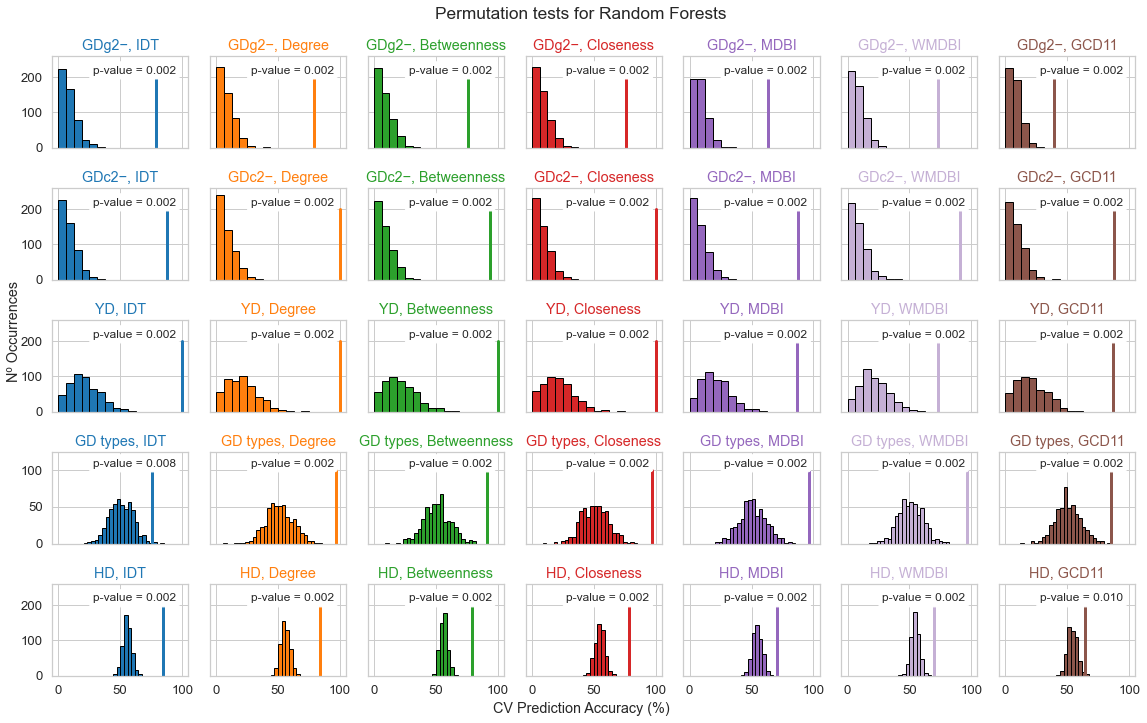

In [44]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, axes = plt.subplots(5, 7, figsize = (16,10), sharey='row', sharex='col')
        colors = treat_colors
        ylim = [0,200]
        treatments = ['IDT', 'Degree', 'Betweenness', 'Closeness', 'MDBI', 'WMDBI', 'GCD11']
        
        for row, dskey in enumerate(datasets):

            to_plot = [p for p in permuts_RF if p['dataset'] == dskey]

            n_labels = len(datasets[dskey]['target'])
            n_bins = 34 if dskey in ('vitis_types', 'HD') else 16
            
            if dskey == 'vitis_types':
                ylim = [0,100]
            else:
                ylim = [0,200]

            for ax, p, tname, color in zip(axes[row].ravel(), to_plot, treatments, colors):
                ax.hist(np.array(p['permutations'])*100, range=(0, 100.01), label=name + ' Permutations',
                        bins=n_bins, edgecolor='black', color=color)
                #ax.axvline(p['non_permuted_CV']*100)

                ax.plot(2 * [p['non_permuted_CV'] * 100], ylim, '-', linewidth=3, color=color, #alpha = 0.5,
                         label=name + ' (pvalue %.5f)' % p['p-value'], solid_capstyle='round')

                props = dict(boxstyle='round', facecolor='white', alpha=1)
                
                if dskey != 'vitis_types':
                    ax.text(95, 210, 'p-value = %.3f' % p['p-value'], bbox=props, ha='right', fontsize='small')
                    ax.set_title(f"{endminus(datasets[dskey]['name'])}, {tname}", color=color)
                    ax.set_ylim(0,260)
                else:
                    ax.text(95, 105, 'p-value = %.3f' % p['p-value'], bbox=props, ha='right', fontsize='small')
                    ax.set_title(f"{endminus(datasets[dskey]['name'])}, {tname}", color=color)
                    ax.set_ylim(0,125)

        f.text(0.5, 0.015, 'CV Prediction Accuracy (%)', ha='center', va='top')
        f.text(0.008, 0.6, 'Nº Occurrences', ha='center', va='top',rotation=90)
        
        f.suptitle(f'Permutation tests for Random Forests')
        plt.tight_layout()
        f.savefig('images/permutations_RF.pdf', dpi=300)
        f.savefig('images/permutations_RF.jpg', dpi=300)
        plt.show()

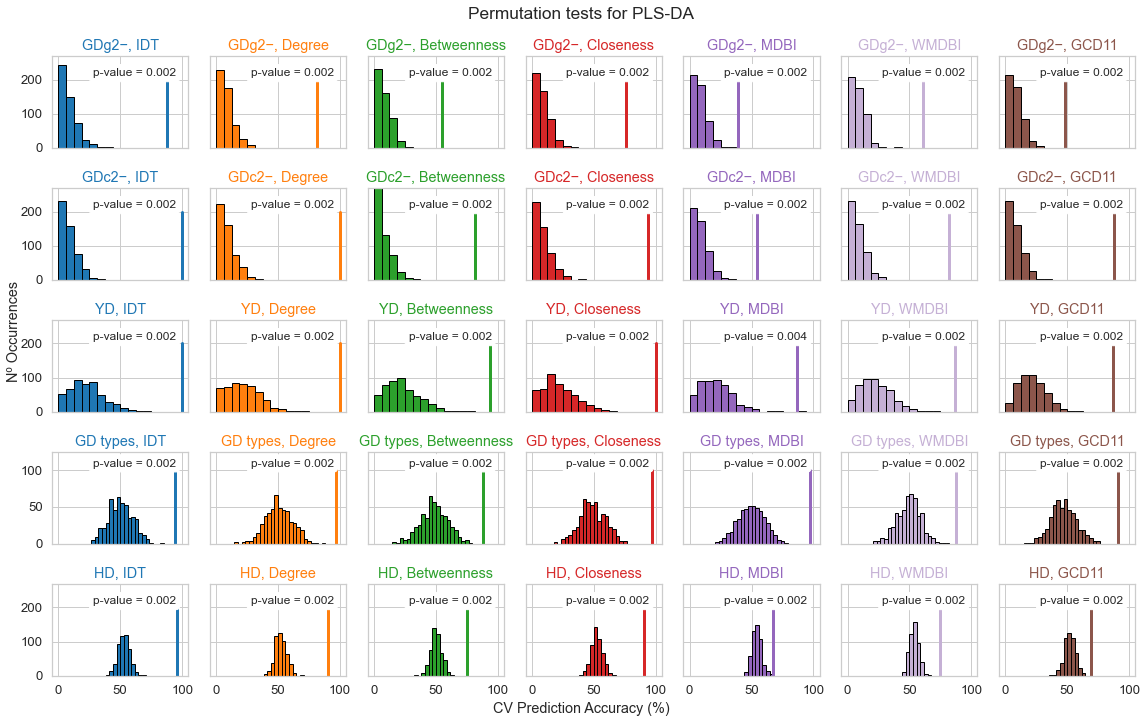

In [45]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, axes = plt.subplots(5, 7, figsize = (16,10), sharey='row', sharex='col')
        colors = treat_colors
        ylim = [0,200]
        treatments = ['IDT', 'Degree', 'Betweenness', 'Closeness', 'MDBI', 'WMDBI', 'GCD11']
        
        for row, dskey in enumerate(datasets):

            to_plot = [p for p in permuts_PLSDA if p['dataset'] == dskey]

            n_labels = len(datasets[dskey]['target'])
            
            n_bins = 34 if dskey in ('vitis_types', 'HD') else 16
            
            if dskey == 'vitis_types':
                ylim = [0,100]
            else:
                ylim = [0,200]


            for ax, p, tname, color in zip(axes[row].ravel(), to_plot, treatments, colors):
                ax.hist(np.array(p['permutations'])*100, range=(0, 100.01), label=name + ' Permutations',
                        bins=n_bins, edgecolor='black', color=color)
                #ax.axvline(p['non_permuted_CV']*100)

                ax.plot(2 * [p['non_permuted_CV'] * 100], ylim, '-', linewidth=3, color=color, #alpha = 0.5,
                         label=name + ' (pvalue %.5f)' % p['p-value'], solid_capstyle='round')

                props = dict(boxstyle='round', facecolor='white', alpha=1)
                
                if dskey != 'vitis_types':
                    ax.text(95, 210, 'p-value = %.3f' % p['p-value'], bbox=props, ha='right', fontsize='small')
                    ax.set_title(f"{endminus(datasets[dskey]['name'])}, {tname}", color=color)
                    ax.set_ylim(0,270)
                else:
                    ax.text(95, 105, 'p-value = %.3f' % p['p-value'], bbox=props, ha='right', fontsize='small')
                    ax.set_title(f"{endminus(datasets[dskey]['name'])}, {tname}", color=color)
                    ax.set_ylim(0,125)

        f.text(0.5, 0.015, 'CV Prediction Accuracy (%)', ha='center', va='top')
        f.text(0.008, 0.6, 'Nº Occurrences', ha='center', va='top',rotation=90)
        
        
        f.suptitle(f'Permutation tests for PLS-DA')
        plt.tight_layout()
        f.savefig('images/permutations_PLSDA.pdf', dpi=300)
        f.savefig('images/permutations_PLSDA.jpg', dpi=300)
        plt.show()

#### Save results as an Excel Table

In [38]:
permuts_PLSDA[0].keys()

dict_keys(['dataset', 'treatment', 'non_permuted_CV', 'permutations', 'p-value'])

In [40]:
l = 0
permut_table = pd.DataFrame(columns=['Dataset', 'Treatment', 'Classifier', 'p-value'])
for i in permuts_RF:
    name = datasets[i['dataset']]['name']
    if name.endswith('-'):
        endminus(name)
    permut_table.loc[l] = (name, i['treatment'], 'RF', i['p-value'])
    l = l+1

for i in permuts_PLSDA:
    name = datasets[i['dataset']]['name']
    if name.endswith('-'):
        endminus(name)
    permut_table.loc[l] = (name, i['treatment'], 'PLS-DA', i['p-value'])
    l = l+1

In [41]:
permut_table.to_excel('Table S2_Perm.xlsx')